<a href="https://colab.research.google.com/github/the-pudding/cook_county/blob/master/Cook_Co_Incarceration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Questions for SAO
:
- Should we use offense_type instead of updated_offense_category? Or offense_title? We could also run the numbers for the latter and see how much they differ.
- Most of the cases where FR_Result is null are narcotics, but some of these are non-drug cases. Does null always mean that it bypasses felony review?
- We should confirm that our mapping of charge_disposition and charge_disposition_reason is accurate.
- What is the current_sentence flag in the sentencing table?
- Can we assume that charges dismissed in intake mean that the person will not appear in disposition/sentencing?
- To calculate approval rates, we divide total approved rows in the intake table (`fr_result` = `approved`) by total rows where `fr_result` is not null. Is this accurate?

Model Questions:
- We average monthly unapproval rates when projection numbers under each term. Please look carefully at that line and tell me if anything seems fishy.



Outstanding Analysis:
- Confirm that primary_charge is correctly used in disposition
- Check if case_participant_ids unapproved in intake appear in disposition (i.e., do dismissed charges equate to people leaving the system)
- Confirm that a breakout offense_type by felony class does not change the model.
- For weapons charges, should we see if those have decreased in felony class?
- For narcotics charges, should we see if those have decreased in felony class?
- Are charges resulting less in prison? On first glance it looks like they are, resulting in more probation and jail.
- We should confirm that unapproved charges in intake do not mean that the case_participant_id moves into disposition due to other charges
- We should check that are unapproval rates match anything released by SAO in their PDFs.
- Confirm that disposition case ids are also in intake case ids and see if unapproved cases can make it into disposiiton.
- Look at changes in how cases are plead down from Alvarez to Foxx.
- For gun charges (where she's invested), see if win rate is going up.

#Setup

These cells load the neccessary libraries and data from SAO.

In [0]:
!pip install pandas
!pip install sodapy
!pip install numpy
!pip install monthdelta

    100% |████████████████████████████████| 829kB 22.4MB/s 
    100% |████████████████████████████████| 61kB 22.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future
google-colab 1.0.0 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4


  Stored in directory: /root/.cache/pip/wheels/5e/e9/68/c0cb0cefe6fdd49ce42a99196b272748d2d823c18c7af612cf
Successfully built monthdelta


In [0]:
#@markdown Imports and API Access

import warnings
warnings.filterwarnings("ignore")
import time
import datetime as dt
import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import OrderedDict 

# Authenticated client (needed for non-public datasets):
client_link = 'datacatalog.cookcountyil.gov'
wjztoken    = 'aFpl9dxptMD8U7HBwwezf0VTj'
wjzuser     = 'walterzielenski@gmail.com'
wjzpass     = '6a3Mu*dSTB5d$i0AX%'
client      = Socrata(client_link, 
                      wjztoken, 
                      username = wjzuser, 
                      password = wjzpass)

# # ------------------------------ #
  
ids =     {'initiation':'7mck-ehwz',   
           'disposition':'apwk-dzx8',  
           'sentencing':'tg8v-tm6u',   
#           'intake':'a2mv-5et6'}   
#           'intake':'pmqy-gxnr'}   

          'intake':'3k7z-hchi'}  


arch_ids = {'initiation':'qr2q-atnt',    
            'disposition':'75tm-jf99', 
            'sentencing':'qhfs-h477',    
            'intake':'a2mv-5et6'}       

entry_limit = 400000


Here we set the start date for Alvarez and end date.

We take the amount of time Foxx has been in office, and a recirocal timeframe for her predecessor, Anita Alvarez, in the months leading up to Foxx taking office.


In [0]:
alv_start  = '2015-02'
alv_end    = '2016-11'
foxx_start = '2016-12'
foxx_end   = None


In [0]:
import monthdelta as md

foxx_takes_office_month = dt.datetime(2016,12,31)

# foxx_term_length = min([num_months for num_months in [diff_month(max(df_index_range.index),foxx_takes_office_month) for df_index_range in [df_disposition]]])
foxx_term_length = 24

alv_start = dt.datetime(2016,12,31) - md.monthdelta(24)
foxx_end  = dt.datetime(2016,12,31) + md.monthdelta(24)

alv_term  = pd.date_range(alv_start,'11/30/16')
foxx_term = pd.date_range('12/31/16',foxx_end)

alv_term = alv_term.date
foxx_term = foxx_term.date

# Intake

Here we query the data for intake. Note that we only return fields where `fr_result` is null. This is an **assumption** (currently emailed to SAO to confirm), that null `fr_result` rows are not reviewed and approved by prosectors.

In [0]:

query_id    = ids['intake']
select_soql = 'case_participant_id,offense_category,race,law_enforcement_agency,fr_date,fr_result,update_offense_category'
group_soql  = ''

# we remove fr_results that are null. See note above.
where_soql  = 'fr_result is not null'
order_soql  = ''
results_before = client.get(query_id, 
                            select = select_soql, 
                            #group = group_soql,
                            where  = where_soql, 
                            #order = order_soql
                            limit = entry_limit #note that we need to set a limit, otherwise it only returns 1000 rows.
                           )

df = pd.DataFrame.from_records(results_before)
df_intake_backup = df.copy()

Here we convert the `fr_date` to a date_time that is filterable by code. We also remove months where there was less than 500 cases. This is due to what seems to be errors in the SAO's data, with some cases appearing with a date in the future (e.g., 2025). This removes such cases.

In [0]:
# Turn fr_date into datetime format, if it isn't.
df['fr_date'] = pd.to_datetime(df['fr_date'], errors='coerce')

# Find months with less than 500 months for later removal
temp = df.set_index('fr_date').resample('M').count()['fr_result'] < 500
empty_months = list(temp[temp==1].index)
empty_months_intake = empty_months.copy()

# Create dfs for all cases, and ones which were approved.
df_all = df.copy()
df_all_intake = df_all.copy
df_app = df_all[df_all['fr_result'] == 'Approved'] #only approved cases

# Pivot by offense, resample monthly, and drop months with less than 500 cases.
dfp_all = df_all.pivot_table(columns='offense_category', index='fr_date', values='fr_result', aggfunc='count', fill_value = 0).resample('M').sum().drop(empty_months)
dfp_app = df_app.pivot_table(columns='offense_category', index='fr_date', values='fr_result', aggfunc='count', fill_value = 0).resample('M').sum().drop(empty_months)

Let's look at all our data. Note that this is using offense_category (not updated_offense_category)

In [0]:
display(dfp_all[:5])

update_offense_category,Aggravated Assault Police Officer,Aggravated Assault Police Officer Firearm,Aggravated Battery,Aggravated Battery Police Officer,Aggravated Battery With A Firearm,Aggravated DUI,Aggravated Discharge Firearm,Aggravated Fleeing and Eluding,Aggravated Identity Theft,Aggravated Robbery,...,Tampering,Theft,Theft by Deception,UUW - Unlawful Use of Weapon,Unlawful Restraint,Vehicular Hijacking,Vehicular Invasion,Violate Bail Bond,Violation Order Of Protection,Violation of Sex Offender Registration
fr_date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,1,0,20,38,38,190,5,23,0,27,...,0,77,1,232,3,6,0,0,6,0
2011-02-28,0,0,29,35,17,162,5,10,1,16,...,0,69,0,188,1,1,0,0,8,0
2011-03-31,1,0,38,43,45,199,4,17,0,12,...,0,78,0,237,2,3,0,0,3,0
2011-04-30,1,0,39,48,49,214,8,11,5,16,...,0,63,4,267,1,12,0,0,1,0
2011-05-31,1,0,43,53,38,208,7,22,3,16,...,0,87,1,296,1,8,0,0,2,0


In [0]:
easeoff_offenses     = ['Retail Theft','Driving With Suspended Or Revoked License']
crackdown_offenses   = ['UUW - Unlawful Use of Weapon','Possession of Stolen Motor Vehicle']
target_offenses      = easeoff_offenses + crackdown_offenses
confusing_offenses   = ['Aggravated Battery', 'Domestic Battery', 'Homicide']
untargeted_offenses  = list(dfp_all.columns.difference(target_offenses))

In [0]:
foxx_groups = {'easing up':     easeoff_offenses,
               'cracking down': crackdown_offenses,
               'not targeting': untargeted_offenses}

dfp_target = pd.DataFrame(index = dfp_all.index)
for group_name, group_list in foxx_groups.items():
   dfp_target = dfp_target.join(dfp_app[group_list].sum(axis=1).rename('Approved Offenses which Foxx is {}'.format(group_name)))
   dfp_target = dfp_target.join(dfp_all[group_list].sum(axis=1).rename('Total Offenses which Foxx is {}'.format(group_name)))

cols = list(dfp_target.columns)
dfp_target_rates = pd.DataFrame(index = dfp_all.index)


In [0]:
y_div_all  = dfp_all[crackdown_offenses[::-1]].join(dfp_all[easeoff_offenses[::-1]]).join((dfp_all[untargeted_offenses].sum(axis=1)).rename('Untargeted Offenses'))
y_div_app  = dfp_app[crackdown_offenses[::-1]].join(dfp_app[easeoff_offenses[::-1]]).join((dfp_app[untargeted_offenses].sum(axis=1)).rename('Untargeted Offenses'))

dfp_diverted = pd.DataFrame(index = dfp_all.index)
for offense in y_div_all.columns[::-1]:
  dfp_diverted = dfp_diverted.join((y_div_all[offense] - y_div_app[offense]).rename(offense))

In [0]:
#@markdown Total number of cases which went Unapproved for each of her targeted Offenses, since December 1, 2016:

foxx_diverted = dfp_diverted.loc['2016-12':].sum().rename('Cases Diverted from Court (Unapproved by FRU) Since Dec 1, 2016:').to_frame().transpose()
foxx_diverted['Total'] = foxx_diverted.sum(axis=1)
display(foxx_diverted)

,Untargeted Offenses,Retail Theft,Driving With Suspended Or Revoked License,UUW - Unlawful Use of Weapon,Possession of Stolen Motor Vehicle,Total
"Cases Diverted from Court (Unapproved by FRU) Since Dec 1, 2016:",5009,2327,252,1337,576,9501


To calculate each DA's unapproval rate, we'll average the monthly unapproval rates by offense.

In [0]:
temp = df.groupby('offense_category').count()['fr_result'] < 500
low_offense_count = list(temp[temp==1].index)

#lets consider the start and end dates for the analysis for each DA term
dfp_div_alvarez = ((dfp_all-dfp_app)/dfp_all).loc[alv_start:alv_end]
alv_mean_unapp = dfp_div_alvarez.mean().rename('Alvarez - 2/15-11/16').to_frame()

dfp_div_foxx = ((dfp_all-dfp_app)/dfp_all).loc[foxx_start:]
foxx_mean_unapp = dfp_div_foxx.mean().rename('Foxx - 12/16-9/18').to_frame()


display(alv_mean_unapp[:5])
display(foxx_mean_unapp[:5])

,Alvarez - 2/15-11/16
offense_category,
Aggravated Assault Police Officer,0.095031
Aggravated Assault Police Officer Firearm,0.033333
Aggravated Battery,0.202360
Aggravated Battery Police Officer,0.055063
Aggravated Battery Police Officer Firearm,0.125000


,Foxx - 12/16-9/18
offense_category,
Aggravated Assault Police Officer,0.197075
Aggravated Assault Police Officer Firearm,0.346154
Aggravated Battery,0.220732
Aggravated Battery Police Officer,0.092470
Aggravated Battery Police Officer Firearm,0.000000


Let's also look at the unapproval rate by totaling all cases for each DAs term, rather than taking a monthly average, and confirm there isn't a material difference.

In [0]:
dfp_alv_all = dfp_all.loc[alv_start:alv_end]
dfp_alv_app = dfp_app.loc[alv_start:alv_end]

alv_total_unapproved = (dfp_alv_all.sum() - dfp_alv_app.sum()) / dfp_alv_all.sum()
delta = (alv_total_unapproved - dfp_div_alvarez.mean()).rename('difference').to_frame()
delta

,difference
offense_category,
Aggravated Assault Police Officer,0.003183
Aggravated Assault Police Officer Firearm,0.038095
Aggravated Battery,-0.003602
Aggravated Battery Police Officer,-0.001571
Aggravated Battery Police Officer Firearm,0.000000
Aggravated Battery With A Firearm,-0.018589
Aggravated DUI,-0.001079
Aggravated Discharge Firearm,0.004666
Aggravated Fleeing and Eluding,-0.003978


The differences look nominal, especially for major offenses that represent the bulk of cases in SAO.

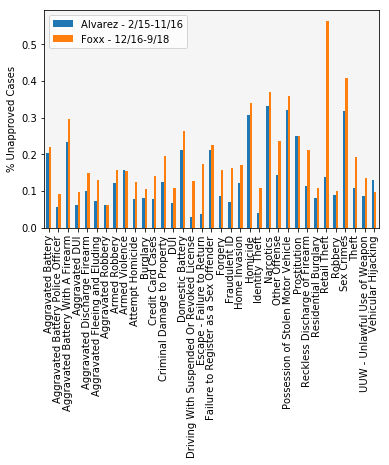

In [0]:
all_unapp = alv_mean_unapp.join(foxx_mean_unapp)
all_unapp.drop(low_offense_count).plot(kind='bar')
plt.ylabel('% Unapproved Cases')
plt.xlabel(None)
plt.gca().set_facecolor('whitesmoke')
plt.margins(x=0)

To guage the effect Kim Foxx's influence had on the number of people diverted from Court, there are three schools of thought:

**Case 1**: Keep Alvarez' law enforcement activity consistent through Foxx's term. That is to say, assume Kim Foxx's influence does not effect law enforcement, and the number of cases seen by FRU is the same as it was in the 23 months prior to her election. 

**Case 2**: Simulate Alvarez' unapproval rate in Foxx's term, as law enforcement acts on her influence and policy changes.

**Case 3**: Isolate either DAs in their time periods and compare raw numbers of people diverted per offense.

These three considerations provide a difference of over 950 people being diverted from their case being heard in court.


In [0]:
# Get all cases for all offenses within each DA's period of interest.
all_cases_alv        = dfp_all.loc[alv_start:alv_end].sum().rename('All Cases to FRU//Alvarez').to_frame()
all_cases_foxx       = dfp_all.loc[foxx_start:].sum().rename('All Cases to FRU//Foxx').to_frame()

display(all_cases_alv[:5])

,All Cases to FRU//Alvarez
offense_category,
Aggravated Assault Police Officer,112
Aggravated Assault Police Officer Firearm,42
Aggravated Battery,1288
Aggravated Battery Police Officer,1346
Aggravated Battery Police Officer Firearm,8


In [0]:
alv_mean_alv_total   = (alv_mean_unapp.iloc[:,0]*all_cases_alv.iloc[:,0]).rename('Alv Mean, Alv Total').to_frame()
foxx_mean_alv_total  = (foxx_mean_unapp.iloc[:,0]*all_cases_alv.iloc[:,0]).rename('Foxx Mean, Alv Total').to_frame()
diff_alv_total       = (foxx_mean_alv_total.iloc[:,0] - alv_mean_alv_total.iloc[:,0]).rename('Δ Case 1').to_frame()

display(foxx_mean_alv_total[:5])

,"Foxx Mean, Alv Total"
offense_category,
Aggravated Assault Police Officer,22.072428
Aggravated Assault Police Officer Firearm,14.538462
Aggravated Battery,284.303087
Aggravated Battery Police Officer,124.464825
Aggravated Battery Police Officer Firearm,0.000000


In [0]:
# Case 1: Multiply each DA's Unapproval Rate by Alvarez' Case Totals.
alv_mean_alv_total   = (alv_mean_unapp.iloc[:,0]*all_cases_alv.iloc[:,0]).rename('Alv Mean, Alv Total').to_frame()
foxx_mean_alv_total  = (foxx_mean_unapp.iloc[:,0]*all_cases_alv.iloc[:,0]).rename('Foxx Mean, Alv Total').to_frame()
diff_alv_total       = (foxx_mean_alv_total.iloc[:,0] - alv_mean_alv_total.iloc[:,0]).rename('Δ Case 1').to_frame()

# Case 2: Multiply each DA's Unapproval Rate by Foxx's Case Totals; Foxx's diversions vs. what Alvarez "would have" diverted in her term
alv_mean_foxx_total  = (alv_mean_unapp.iloc[:,0]*all_cases_foxx.iloc[:,0]).rename('Alv Mean, Foxx Total').to_frame()
foxx_mean_foxx_total = (foxx_mean_unapp.iloc[:,0]*all_cases_foxx.iloc[:,0]).rename('Foxx Mean, Foxx Total').to_frame()
diff_foxx_total      = (foxx_mean_foxx_total.iloc[:,0] - alv_mean_foxx_total.iloc[:,0]).rename('Δ Case 2').to_frame()

# Case 3: Count the number of Unapproved Cases by Offense for either DA and find the difference.
diff_norm_total      = (foxx_mean_foxx_total.iloc[:,0] - alv_mean_alv_total.iloc[:,0]).rename('Δ Case 3').to_frame()

In [0]:
foxx_mean_unapp.iloc[:,0]

offense_category
Aggravated Assault Police Officer                0.197075
Aggravated Assault Police Officer Firearm        0.346154
Aggravated Battery                               0.220732
Aggravated Battery Police Officer                0.092470
Aggravated Battery Police Officer Firearm        0.000000
Aggravated Battery With A Firearm                0.294941
Aggravated DUI                                   0.096095
Aggravated Discharge Firearm                     0.149437
Aggravated Fleeing and Eluding                   0.131155
Aggravated Identity Theft                        0.030769
Aggravated Robbery                               0.061932
Aggravated Robbery BB Gun                        0.166667
Armed Robbery                                    0.156113
Armed Violence                                   0.154455
Arson                                            0.216587
Arson and Attempt Arson                          0.148148
Attempt Armed Robbery                            0.1456

In [0]:
df_compare1 = pd.concat([all_cases_alv,all_cases_foxx,diff_alv_total,diff_foxx_total,diff_norm_total],axis=1)
df_comp_other = df_compare1.drop(target_offenses).sum().rename('Untargeted Offenses').to_frame().T
print("Number of Cases Diverted from Court under Kim Foxx")
df_compare1 = df_compare1.loc[target_offenses].append(df_comp_other)
df_compare1 = df_compare1.append(df_compare1.sum().rename('Totals'))
df_compare1.astype(int)

Number of Cases Diverted from Court under Kim Foxx


,All Cases to FRU//Alvarez,All Cases to FRU//Foxx,Δ Case 1,Δ Case 2,Δ Case 3
Retail Theft,7103,4156,3026,1770,1363
Driving With Suspended Or Revoked License,3218,2346,315,229,205
UUW - Unlawful Use of Weapon,6093,9906,293,476,808
Possession of Stolen Motor Vehicle,1281,1688,48,64,194
Untargeted Offenses,27584,28130,1362,1426,1596
Totals,45279,46226,5046,3968,4168


In [0]:
#save df for use in dispositions

df_diversions = df_compare1.astype(int).copy()


Let's make the chart for our article

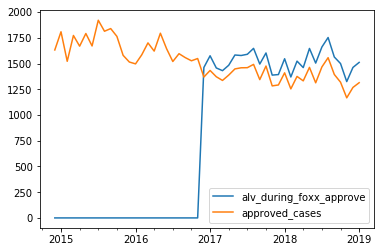

In [0]:
approved_cases = dfp_app.sum(axis=1).rename('approved_cases').to_frame()

approved_case_rate = (dfp_app/dfp_all)
# approved_case_rate

#average approval rate for each month by offense during alvarez's term
alv_approved_case_rate = approved_case_rate.loc[alv_start:alv_end].mean().rename('xrate').to_frame()

#multiply this by monthly cases in Foxx's term
foxx = dfp_all.loc[foxx_start:]

#joined = foxx.join(alv_approved_case_rate)
joined = foxx.transpose().join(alv_approved_case_rate)

#multiply by the approval case rate and sum per month
alv_during_foxx_approved = joined.multiply(joined["xrate"], axis=0).drop('xrate', axis=1).transpose().sum(axis=1).rename('alv_during_foxx_approve').to_frame()

merged = alv_during_foxx_approved.join(approved_cases)



alv_approved = dfp_app[alv_start:alv_end].sum(axis=1).rename('approved_cases').to_frame()
alv_approved["alv_during_foxx_approve"] = 0



merged = merged.append(alv_approved)
merged = merged.sort_index()
merged
merged.drop(merged.index[len(merged)-1]).plot() # drop last row of feb 2019


# Dispositions
Should we include primary charge on this? (it's currently filtered for that)

We also assume that lower charges do not move forward givent he charge_disposition of the primary charge.

We further do not look at outcomes for cases where the offense is not the primary charge.

In [0]:
query_id    = ids['disposition']
entry_limit = 2000000

select_soql = 'updated_offense_category,case_participant_id,primary_charge,offense_title,dispo_date,class,charge_disposition,charge_disposition_reason,gender,race,offense_type'
group_soql  = ''
where_soql  = 'primary_charge = true'
order_soql  = ''
results_before = client.get(query_id, 
                            select = select_soql, 
                            #group = group_soql,
                            where  = where_soql, 
                            #order = order_soql,
                            limit  = entry_limit)

df = pd.DataFrame.from_records(results_before)
df_disposition_backup = df.copy()

In [0]:
df['dispo_date_adjusted'] = pd.to_datetime(df['dispo_date'], format="%m/%d/%Y %H:%M:%S %p", errors='coerce')
temp = df.set_index('dispo_date_adjusted').resample('M').count()['charge_disposition'] < 500
empty_months = list(temp[temp==1].index)
df['dispo_date'] = df['dispo_date_adjusted']

In [0]:
empty_months_dispo = empty_months.copy()

We should confirm that our mapping of charge_disposition and charge_disposition_reason is accurate.

In [0]:
hold        = ['Death Suggested-Cause Abated','Hold Pending Interlocutory','Mistrial Declared','TRAN-FAI','Transferred - Misd Crt','WOWI',]
guilty      = ['BFW','Finding Guilty','Finding Guilty - Amended Charge','Finding Guilty - Lesser Included','Finding Guilty But Mentally Ill','Plea Of Guilty','Plea of Guilty - Amended Charge','Plea of Guilty - Lesser Included','Plea of Guilty But Mentally Ill','Sexually Dangerous Person','Superseded by Indictment','Verdict Guilty','Verdict Guilty - Amended Charge','Verdict Guilty - Lesser Included','Verdict Guilty But Mentally Ill',]
not_guilty  = [y for y in set(x for x in df['charge_disposition']) - set(hold + guilty)]
plea_guilty = ['Plea Of Guilty','Plea of Guilty - Amended Charge','Plea of Guilty - Lesser Included','Plea of Guilty But Mentally Ill']
# Plea deal evident in 'charge_disposition_reason'...leads to Nolle Prosecution for the charge listed.
plea_deal   = ['PG to Misdemeanor','PG to Other Count/s','Proceeding on Other Case/s','Proceeding on Other Count/s']

In [0]:


foxx_cats = {
    'Retail Theft'                              : ['RETAIL THEFT'],
    'Driving With Suspended Or Revoked License' : ['FELONY DRIVING WHILE DRIVER?S LICENSE, PERMIT, OR PRIVILEGE TO OPERATE A MOTOR VEHICLE IS SUSPENDED OR REVOKED'],
    'UUW - Unlawful Use of Weapon'              : ['UNLAWFUL USE OR POSSESSION OF A WEAPON BY A FELON','AGGRAVATED UNLAWFUL USE OF WEAPON']
}

# foxx_cats = {
#     'Retail Theft'                              : ['Retail Theft'],
#     'Driving With Suspended Or Revoked License' : ['Driving With Suspended Or Revoked License'],
#     'UUW - Unlawful Use of Weapon'              : ['UUW - Unlawful Use of Weapon'],
#     'Possession of Stolen Motor Vehicle'        : ['Possession of Stolen Motor Vehicle'] 
# }

foxx_offense_titles = [item for sublist in foxx_cats.values() for item in sublist]

df_dispo = df.copy()



In [0]:
dfp_dispo_all = df_dispo.pivot_table(columns='offense_type', index='dispo_date', values='charge_disposition', aggfunc='count', fill_value = 0).resample('M').sum().drop(empty_months)
dfp_dispo_guilty = df_dispo[df_dispo['charge_disposition'].isin(guilty)].pivot_table(columns='offense_type', index='dispo_date', values='charge_disposition', aggfunc='count', fill_value = 0).resample('M').sum().drop(empty_months)

In [0]:
dfp_dispo_plea_guilty = df_dispo[df_dispo['charge_disposition'].isin(plea_guilty)].pivot_table(columns='offense_type', index='dispo_date', values='charge_disposition', aggfunc='count', fill_value = 0).resample('M').sum().drop(empty_months)
dfp_dispo_plea_deal   = df_dispo[df_dispo['charge_disposition_reason'].isin(plea_deal)].pivot_table(columns='offense_type', index='dispo_date', values='charge_disposition', aggfunc='count', fill_value = 0).resample('M').sum().drop(empty_months, errors = 'ignore')


In [0]:
def dispo_list(df_assoc,time_frame):
  t_s, t_e = time_frame
  temp = pd.DataFrame()
  for cat,cat_list in foxx_cats.items():
    dispo_build = df_assoc[cat_list].loc[t_s:t_e].sum(axis=1).rename(cat).to_frame()
    temp = temp.join(dispo_build,how='outer')

  untargeted_offenses_dispo = df_assoc.drop(foxx_offense_titles,axis=1).loc[t_s:t_e].sum(axis=1).rename('Untargeted Offenses').to_frame()
  temp = temp.join(untargeted_offenses_dispo,how='outer').fillna(0).sum().rename(stat).transpose().to_frame()
  return temp

dispo_stats = {
    'Total Dispo Charges//Alv'  : (dfp_dispo_all,(alv_start,alv_end)),
    'Total Dispo Charges//Foxx' : (dfp_dispo_all,(foxx_start,foxx_end)),
    '# Convicted Alv'           : (dfp_dispo_guilty,(alv_start,alv_end)),
    '# Convicted Foxx'          : (dfp_dispo_guilty,(foxx_start,foxx_end)),
    '# Guilty Plea Alv'         : (dfp_dispo_plea_guilty,(alv_start,alv_end)),
    '# Guilty Plea Foxx'        : (dfp_dispo_plea_guilty,(foxx_start,foxx_end)),
    '# Plea Bargain Alv'        : (dfp_dispo_plea_deal,(alv_start,alv_end)),
    '# Plea Bargain Foxx'       : (dfp_dispo_plea_deal,(foxx_start,foxx_end))}



In [0]:
df_disp_compare = pd.DataFrame()

for stat, data_assoc in dispo_stats.items():
    df_assoc, time_frame = data_assoc
    df_stats = dispo_list(df_assoc, time_frame)
    df_disp_compare = df_disp_compare.join(df_stats,how='outer')

In [0]:
df_disp_compare

,Total Dispo Charges//Alv,Total Dispo Charges//Foxx,# Convicted Alv,# Convicted Foxx,# Guilty Plea Alv,# Guilty Plea Foxx,# Plea Bargain Alv,# Plea Bargain Foxx
Retail Theft,4816,2079,3095,1148,2959,1091,97,123
Driving With Suspended Or Revoked License,2291,2107,1969,1597,1872,1560,107,162
UUW - Unlawful Use of Weapon,2416,3066,1314,1638,1134,1533,116,252
Untargeted Offenses,50517,55309,27219,27755,24709,26551,2381,4185


Find percent of each column as percent of total cases in disposition

In [0]:
dispo_compare = pd.DataFrame()
for DA in ['Alv','Foxx']:  
   da_df = df_disp_compare[[col for col in df_disp_compare if col.endswith(DA)]]
   for col in da_df.columns[1:]:
    da_df[col] = da_df[col]/da_df.iloc[:,0]
   dispo_compare = dispo_compare.join(da_df,how='outer')



Compare rates of convictions, guilty pleas, plea bargains by DA

In [0]:
dispo_percent = dispo_compare.copy()
column_names = list(dispo_percent)
dispo_percent.columns = [w.replace('#', '%') for w in column_names]
dispo_percent

,Total Dispo Charges//Alv,% Convicted Alv,% Guilty Plea Alv,% Plea Bargain Alv,Total Dispo Charges//Foxx,% Convicted Foxx,% Guilty Plea Foxx,% Plea Bargain Foxx
Retail Theft,4816,0.642650,0.614410,0.020141,2079,0.552189,0.524772,0.059163
Driving With Suspended Or Revoked License,2291,0.859450,0.817110,0.046704,2107,0.757950,0.740389,0.076887
UUW - Unlawful Use of Weapon,2416,0.543874,0.469371,0.048013,3066,0.534247,0.500000,0.082192
Untargeted Offenses,50517,0.538809,0.489122,0.047133,55309,0.501817,0.480048,0.075666


In [0]:
# re-arrange the columns
foxx_dispo_col = dispo_compare['Total Dispo Charges//Foxx']
dispo_compare.drop(labels=['Total Dispo Charges//Foxx'], axis=1,inplace = True)
dispo_compare.insert(1, 'Total Dispo Charges//Foxx', foxx_dispo_col)

In [0]:
df_compare2 = dispo_compare.iloc[:,0:2]

for i in range(2,5):
  col_name  = 'Δ' + dispo_compare.columns[i][1:-4]
  alv_stat  = dispo_compare.iloc[:,i]*dispo_compare.iloc[:,0]
  foxx_stat = dispo_compare.iloc[:,i+3]*dispo_compare.iloc[:,0]
  stat_col  = (foxx_stat - alv_stat).rename(col_name)
  df_compare2 = df_compare2.join(stat_col)
  
df_compare2 = df_compare2.append(df_compare2.sum().rename('Totals').T)



In [0]:
print("Change in disposition outcomes via changes in conviction rate, plea rate")
df_compare2

Change in disposition outcomes via changes in conviction rate, plea rate


,Total Dispo Charges//Alv,Total Dispo Charges//Foxx,Δ Convicted,Δ Guilty Plea,Δ Plea Bargain
Retail Theft,4816.0,2079.0,-435.659933,-431.700337,187.929293
Driving With Suspended Or Revoked License,2291.0,2107.0,-232.537257,-175.768391,69.147129
UUW - Unlawful Use of Weapon,2416.0,3066.0,-23.260274,74.000000,82.575342
Untargeted Offenses,50517.0,55309.0,-1868.707371,-458.392197,1441.409463
Totals,60040.0,62561.0,-2560.164835,-991.860924,1781.061227


Let's look at how the upstream reduction in charges would have resulted in disposition outcomes

In [0]:
display(df_diversions["Δ Case 2"])

Retail Theft                                 1749
Driving With Suspended Or Revoked License     231
UUW - Unlawful Use of Weapon                  476
Possession of Stolen Motor Vehicle             44
Untargeted Offenses                          1382
Totals                                       3883
Name: Δ Case 2, dtype: int64

In [0]:
temp = pd.DataFrame()

for i in range(2,5):
  col_name  = 'Δ' + dispo_compare.columns[i][1:-4]
  stat_change = df_diversions["Δ Case 2"]*dispo_compare.iloc[:,i+3]
  temp = temp.join(stat_change.rename(col_name),how='outer')

temp = temp.loc[temp.index.isin(['Retail Theft','Untargeted Offenses','Driving With Suspended Or Revoked License','UUW - Unlawful Use of Weapon'])].astype(int)
df_dispo_upstream = temp.append(temp.sum().rename('Totals').T)
print("Change in disposition outcomes via upstream diversions")
df_dispo_upstream

Change in disposition outcomes via upstream diversions


,Δ Convicted,Δ Guilty Plea,Δ Plea Bargain
Driving With Suspended Or Revoked License,175,171,17
Retail Theft,965,917,103
UUW - Unlawful Use of Weapon,254,238,39
Untargeted Offenses,693,663,104
Totals,2087,1989,263


#Sentencing

Not all cases end up with prison sentences, so we first need to understand the breakdown of sentencing for each offense_type (where it was the primary_charge).

Note that some cases result in multiple charges, and based on manual review of the data, filtering for primary_charge will show all sentencing outcomes for a case_participant (probation, prison, jail, etc.).

Other considerations:
- We do not consider the interaction of other charges on the case in terms of sentencing
- We do not consider offenses where they are not the primary charge (so if retail theft cases appear in sentencing as not the primary charge, they are ignored)


In [0]:

query_id    = ids['sentencing']

select_soql = 'charge_count,current_sentence,primary_charge,updated_offense_category,case_participant_id,offense_title,offense_type,dispo_date,commitment_term,commitment_unit,commitment_type, sentence_type'
group_soql  = ''
where_soql  = 'primary_charge = true'
where_soql  = ''
order_soql  = ''
results_before = client.get(query_id, 
                            select = select_soql, 
                            #group = group_soql,
                            where  = where_soql, 
                            #order = order_soql,
                            limit  = entry_limit)


In [0]:
df = pd.DataFrame.from_records(results_before)
df_sentencing_backup = df.copy()

In [0]:
# Fix formatting of certain numerical columns

df['dispo_date_adjusted'] = pd.to_datetime(df['dispo_date'], format="%m/%d/%Y %H:%M:%S %p", errors='coerce')

temp = df.set_index('dispo_date_adjusted').resample('M').count()['offense_type'] < 500
empty_months = list(temp[temp==1].index)

df['dispo_date'] = df['dispo_date_adjusted']
df = df.set_index('dispo_date').drop(empty_months)
df = df.reset_index()

Let's examine cases where prison appeared in the result for a case_participant

In [0]:
df_has_prison = df.copy()
df_has_prison['resulted_in_prison'] = np.where(df_has_prison['case_participant_id'].isin(df_has_prison.loc[df_has_prison['sentence_type'] == "Prison", 'case_participant_id']), 'yes', 'no')

#rows repeat when there are multiple sentences (e.g., prison and probation).
df_has_prison = df_has_prison.drop_duplicates(subset=['case_participant_id', 'resulted_in_prison'])

#now with a single row per person, we can sum up how often they end up with a prison sentence.
df_has_prison_p = df_has_prison.pivot_table(columns='resulted_in_prison', index='updated_offense_category', values='case_participant_id', aggfunc='count', fill_value = 0)
df_has_prison_p["total"] = df_has_prison_p["no"] + df_has_prison_p["yes"]
df_has_prison_p["prison_percent"] = df_has_prison_p["yes"]/df_has_prison_p["total"]
display(df_has_prison_p)

resulted_in_prison,no,yes,total,prison_percent
updated_offense_category,,,,
Aggravated Assault Police Officer,88,106,194,0.546392
Aggravated Battery,1486,962,2448,0.392974
Aggravated Battery Police Officer,2503,1937,4440,0.436261
Aggravated Battery With A Firearm,264,1963,2227,0.881455
Aggravated DUI,9788,4529,14317,0.316337
Aggravated Discharge Firearm,86,254,340,0.747059
Aggravated Fleeing and Eluding,888,791,1679,0.471114
Aggravated Identity Theft,42,41,83,0.493976
Aggravated Robbery,393,829,1222,0.678396


In [0]:

df_sentencing_backup = df.copy()

df_prison = df.loc[df['sentence_type'] == "Prison"]
commitmentsToExclude = ['Term', 'Dollars']
df_prison = df_prison.loc[~df_prison['commitment_unit'].isin(commitmentsToExclude)]

time_values = {
    'Year(s)'     : [1],
    'Months'      : [float(1/12)],
    'Days'        : [float(1/365.25)],
    'Term'        : [0],
    'Natural Life': [np.nan],
    'Dollars'     : [0],
    'Hours'       : [float(1/8765.82)],
    'Weeks'       : [float(1/52.1429)],
    'Pounds'      : [0],
    'Kilos'       : [0],
    'Ounces'      : [0]
}

df_time_vals = pd.DataFrame.from_dict(time_values).transpose().reset_index()
df_time_vals = df_time_vals.rename(columns={'index':'commitment_unit',0:'years'})


df_prison = df_prison.merge(df_time_vals,on='commitment_unit')


In [0]:
df_prison['commitment_term_numeric'] = pd.to_numeric(df_prison['commitment_term'])
df_prison['commitment_term_numeric'].unique()
df_prison['sentence'] = df_prison['commitment_term_numeric'] * df_prison['years']
df_prison['lifetimes'] = (df_prison['commitment_unit'] == 'Natural Life').astype(int)


Should we do mean or median?

In [0]:
# """
# temp = pd.DataFrame()
# for cat,cat_list in foxx_cats.items():
#   dispo_build = df_assoc[sentence].loc[foxx_start,foxx_end].sum(axis=1).rename(cat).to_frame()
#   temp = temp.join(dispo_build,how='outer')
# untargeted_offenses_dispo = df_assoc.drop(foxx_offense_titles,axis=1).loc[foxx_start,foxx_end].sum(axis=1).rename('Untargeted Offenses').to_frame()
# temp = temp.join(untargeted_offenses_dispo,how='outer').fillna(0).sum().rename(stat).transpose().to_frame()
# return temp
# """

df_sentences = df_prison.pivot_table(columns='offense_type', index='dispo_date', values='sentence', aggfunc='mean', fill_value = np.nan).loc[foxx_start:foxx_end].resample('M').mean().mean(axis=0).rename('Sentence in Years').to_frame()
df_lifetimes = df_prison.pivot_table(columns='offense_type', index='dispo_date', values='lifetimes', aggfunc='mean', fill_value = np.nan).loc[foxx_start:foxx_end].resample('M').mean().mean(axis=0).rename('Sentence in Lifetimes').to_frame()

In [0]:
foxx_cats = {
    'Retail Theft'                              : ['Retail Theft'],
    'Driving With Suspended Or Revoked License' : ['Driving With Suspended Or Revoked License'],
    'UUW - Unlawful Use of Weapon'              : ['UUW - Unlawful Use of Weapon'],
    'Possession of Stolen Motor Vehicle'        : ['Possession of Stolen Motor Vehicle'] 
}

foxx_offense_titles = [item for sublist in foxx_cats.values() for item in sublist]

In [0]:

df_years = pd.DataFrame()
for cat, cat_list in foxx_cats.items():
  cat_list = [w for w in cat_list]
  df_years = df_years.append(df_sentences.T[cat_list].T.mean().rename(cat))
 

df_years = df_years.append(df_sentences.T.drop(foxx_offense_titles,axis=1).T.mean().rename('Untargeted Offenses')) 
df_years = df_years.append(df_sentences.mean().rename('Totals'))




In [0]:
df_years

,Sentence in Years
Retail Theft,1.687964
Driving With Suspended Or Revoked License,1.311790
UUW - Unlawful Use of Weapon,3.285851
Possession of Stolen Motor Vehicle,3.694175
Untargeted Offenses,4.964646
Totals,4.837995


Years sentenced due to disposition changes in Foxx vs. Alvarez (using count of fewer convictions * avg years per conviction).

We still need to adjust this for percent of cases that result in prison (e.g., retail theft is 54%)

In [0]:
# df_lifetimes.T[cat_list]
# for cat, cat_list in foxx_cats.items():
#   print(foxx_cats.items())
#  df_lives = df_lives.append(df_lifetimes.T[cat_list].T.mean().rename(cat))

# df_lives = pd.DataFrame()
# for cat, cat_list in foxx_cats.items():
#   df_lives = df_lives.append(df_lifetimes.T[cat_list].T.mean().rename(cat))
# df_lives = df_lives.append(df_lifetimes.T.drop(foxx_offense_titles,axis=1).T.mean().rename('Untargeted Offenses')) 
# df_lives = df_lives.append(df_lifetimes.mean().rename('Totals'))


#df_years.iloc[:,0]
#df_compare2['Δ Convicted']

df_compare2['Δ Years Sentenced'] = df_years.iloc[:,0] * df_compare2['Δ Convicted']
df_compare2

# df_compare2['Δ Lives Sentenced'] = df_lives.iloc[:,0] * df_compare2['Δ Convicted']

# average_sentences = df_years.join(df_lives).rename(columns={'Sentence in Years':'Avg Term Sentence','Sentence in Lifetimes':'Avg Lifetime Sentence'})

# display(df_compare2.astype(int))

# display(average_sentences)

,Total Dispo Charges//Alv,Total Dispo Charges//Foxx,Δ Convicted,Δ Guilty Plea,Δ Plea Bargain,Δ Years Sentenced
Retail Theft,4816.0,2079.0,-435.659933,-431.700337,187.929293,-735.378292
Driving With Suspended Or Revoked License,2291.0,2107.0,-232.537257,-175.768391,69.147129,-305.039984
UUW - Unlawful Use of Weapon,2416.0,3066.0,-23.260274,74.000000,82.575342,-76.429799
Untargeted Offenses,50517.0,55309.0,-1868.707371,-458.392197,1441.409463,-9277.470532
Totals,60040.0,62561.0,-2560.164835,-991.860924,1781.061227,-12386.063741


Sentencing outcome for upstream changes in diversions

In [0]:
df_sent_upstream = df_dispo_upstream.copy()
df_years.iloc[:,0]
df_compare2['Δ Convicted']
df_sent_upstream['Δ Years Sentenced'] = df_years.iloc[:,0] * df_dispo_upstream['Δ Convicted']
df_sent_upstream


,Δ Convicted,Δ Guilty Plea,Δ Plea Bargain,Δ Years Sentenced
Driving With Suspended Or Revoked License,175,171,17,229.563202
Retail Theft,965,917,103,1628.885280
UUW - Unlawful Use of Weapon,254,238,39,834.606207
Untargeted Offenses,693,663,104,3440.499662
Totals,2087,1989,263,10096.894808


#Narcotics Analysis

Here we analyze how disposition outcomes have changed for Foxx vs. Alvarez in narcotics cases. Since Foxx cannot divert narcotics cases in intake (charges are directly brought by police,) the hypothesis is that Foxx might be dismissing more cases via Finding of no probable cause (FNPC) or Nolle prosequi in disposition.

In [0]:
!pip install monthdelta


  Stored in directory: /root/.cache/pip/wheels/5e/e9/68/c0cb0cefe6fdd49ce42a99196b272748d2d823c18c7af612cf
Successfully built monthdelta


In [0]:
import monthdelta as md

foxx_takes_office_month = dt.datetime(2016,12,31)

# foxx_term_length = min([num_months for num_months in [diff_month(max(df_index_range.index),foxx_takes_office_month) for df_index_range in [df_disposition]]])
foxx_term_length = 24

alv_start = dt.datetime(2016,12,31) - md.monthdelta(24)
foxx_end  = dt.datetime(2016,12,31) + md.monthdelta(24)

alv_term  = pd.date_range(alv_start,'11/30/16')
foxx_term = pd.date_range('12/31/16',foxx_end)

alv_term = alv_term.date
foxx_term = foxx_term.date

In [0]:
df_disposition = df_dispo.copy()

In [0]:
df_disposition["dispo_date_time_ignored"] = df_disposition["dispo_date_adjusted"].dt.date

In [0]:
# df_disposition[df_disposition['updated_offense_category']=="Narcotics"]["offense_type"].value_counts()

In [0]:
cadef disposition_data_compare(term,offense):
  df_dispo_term = df_disposition.loc[df_disposition["dispo_date_time_ignored"].isin(term)]
  df_dispo_term = df_dispo_term[df_dispo_term['offense_type']=="POSSESSION OF A CONTROLLED SUBSTANCE"]
  offense_data   = df_dispo_term[df_dispo_term['updated_offense_category']==offense_name]['charge_disposition'].value_counts().rename('Number of '+offense+' Cases').to_frame()
  offense_data['% of '+offense+' Cases'] = offense_data['Number of '+offense+' Cases'] / offense_data['Number of '+offense+' Cases'].sum()
#     all_other_data = df_dispo_term[df_dispo_term['updated_offense_category']!=offense_name]['charge_disposition'].value_counts().rename('Number of Other Cases').to_frame()
#     all_other_data['% of Other Cases'] = all_other_data['Number of Other Cases'] / all_other_data['Number of Other Cases'].sum()

#     res = offense_data.join(all_other_data,how = 'outer').fillna(0).sort_values('Number of '+offense_name+' Cases',ascending=False)
  return offense_data.loc[offense_data["Number of "+offense+" Cases"] > 30].sort_values('Number of '+offense+' Cases',ascending=False)

In the following tables, we see that Foxx has increased the number of Nolle Prosecution	for charge_disposition, but taken with FNPC, there doesn't seem to be any meaningful change between Foxx and Alvarez, even on Cannibis charges. There is no data in charge_disposition_reason, other than Noelle - AONIC (to ask SAO for a definition)

In [0]:
offense_name = "Narcotics"
offense_type = "POSSESSION OF A CONTROLLED SUBSTANCE"
print("stats for "+offense_type)
for da,term in {'Alvarez':alv_term,'Foxx':foxx_term}.items():

  print('\n'+da)  
  
  display(disposition_data_compare(term,offense_type))

stats for POSSESSION OF A CONTROLLED SUBSTANCE

Alvarez


,Number of POSSESSION OF A CONTROLLED SUBSTANCE Cases,% of POSSESSION OF A CONTROLLED SUBSTANCE Cases
Nolle Prosecution,5591,0.329911
Plea Of Guilty,5540,0.326902
FNPC,5201,0.306898
Finding Guilty,309,0.018233
FNG,119,0.007022
BFW,47,0.002773
Transferred - Misd Crt,37,0.002183
Case Dismissed,37,0.002183
Death Suggested-Cause Abated,31,0.001829



Foxx


,Number of POSSESSION OF A CONTROLLED SUBSTANCE Cases,% of POSSESSION OF A CONTROLLED SUBSTANCE Cases
Nolle Prosecution,7497,0.501606
Plea Of Guilty,4905,0.328181
FNPC,2271,0.151947
Finding Guilty,83,0.005553
Case Dismissed,71,0.004750
FNG,35,0.002342


In [0]:
offense_name = "Narcotics"
offense_type = "POSSESSION OF CANNABIS"
print("stats for "+offense_type)
for da,term in {'Alvarez':alv_term,'Foxx':foxx_term}.items():

  print('\n'+da)  
  
  display(disposition_data_compare(term,offense_type))

stats for POSSESSION OF CANNABIS

Alvarez


,Number of POSSESSION OF CANNABIS Cases,% of POSSESSION OF CANNABIS Cases
Nolle Prosecution,5591,0.329911
Plea Of Guilty,5540,0.326902
FNPC,5201,0.306898
Finding Guilty,309,0.018233
FNG,119,0.007022
BFW,47,0.002773
Transferred - Misd Crt,37,0.002183
Case Dismissed,37,0.002183
Death Suggested-Cause Abated,31,0.001829



Foxx


,Number of POSSESSION OF CANNABIS Cases,% of POSSESSION OF CANNABIS Cases
Nolle Prosecution,7497,0.501606
Plea Of Guilty,4905,0.328181
FNPC,2271,0.151947
Finding Guilty,83,0.005553
Case Dismissed,71,0.004750
FNG,35,0.002342


#Archived Analysis


In [0]:
#.head(10).append(disposition_data_compare(term).sum().rename('Totals')))


In [0]:
df_all['fr_result'].value_counts()

# empty_months_intake
#df_all_intake = df_all.copy
# df_app = df_all[df_all['fr_result'] == 'Approved'] #only approved cases
# Pivot by offense, resample monthly, and drop months with less than 500 cases.
# df_all_intake_p = df_all.pivot_table(columns='UPDATE_OFFENSE_CATEGORY', index='fr_date', values='fr_result', aggfunc='count', fill_value = 0).resample('M').sum().drop(empty_months)
# df_all_intake_p["Narcotics"]
# df_all_intake
# dfp_app = df_app.pivot_table(columns='offense_category', index='fr_date', values='fr_result', aggfunc='count', fill_value = 0).resample('M').sum().drop(empty_months)

Approved                                      164257
Rejected                                       16942
Continued Investigation                         6846
Felony Review                                   2438
Victim Sensitive Interview                       265
Advice                                           238
Disregard                                        208
Arrest Warrant                                    35
Warr Ord Warr Issued                              26
Deputy Override                                   22
VICTIM SENSITIVE INT                              19
Search Warrant                                    16
Chief Judge Assignment To Felony Courtroom        14
Warrant Exec                                      10
Screen Felony                                      7
Charge(S) Approved                                 2
Name: fr_result, dtype: int64

In [0]:

query_id    = ids['intake']
select_soql = 'received_date,case_participant_id,offense_category,race,law_enforcement_agency,fr_date,fr_result,UPDATE_OFFENSE_CATEGORY'
group_soql  = ''

# we remove fr_results that are null. See note above.
order_soql  = ''
results_before = client.get(query_id, 
                            select = select_soql, 
                            #group = group_soql,
                            #where  = where_soql, 
                            #order = order_soql
                            limit = entry_limit #note that we need to set a limit, otherwise it only returns 1000 rows.
                           )

df = pd.DataFrame.from_records(results_before)
df_intake_backup = df.copy()

In [0]:
# Turn fr_date into datetime format, if it isn't.
df['fr_date'] = pd.to_datetime(df['fr_date'], errors='coerce')
df['received_date'] = pd.to_datetime(df['received_date'], errors='coerce')

# Find months with less than 500 months for later removal
temp = df.set_index('fr_date').resample('M').count()['fr_result'] < 500
empty_months = list(temp[temp==1].index)
empty_months_intake = empty_months.copy()

# Create dfs for all cases, and ones which were approved.
df_all = df.copy()
df_all_narcotics = df_all.loc[df_all["UPDATE_OFFENSE_CATEGORY"] == "Narcotics"]
display(df_all_narcotics[:5])

,UPDATE_OFFENSE_CATEGORY,case_participant_id,fr_date,fr_result,law_enforcement_agency,offense_category,race,received_date
4,Narcotics,141459971640,NaT,NaN,SPEC. OPERATIONS,PROMIS Conversion,HISPANIC,2011-01-31
5,Narcotics,449692103372,NaT,NaN,SPEC. OPERATIONS,PROMIS Conversion,HISPANIC,2011-01-31
7,Narcotics,459015687748,2010-12-16,Approved,CHICAGO PD,UUW - Unlawful Use of Weapon,Black,2011-01-31
8,Narcotics,459077673743,2010-12-16,Approved,CHICAGO PD,UUW - Unlawful Use of Weapon,Black,2011-01-31
40,Narcotics,459463316926,2011-01-01,Rejected,CHICAGO PD,Armed Robbery,Black,2011-01-01
